In [1]:
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import env
from pydataset import data
from scipy.stats import pearsonr, spearmanr
import scipy
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import explained_variance_score
import statsmodels.api as sm
import acquire
import prepare

# Scenario
You are a junior data scientist on the Zillow data science team and recieve the following email in your inbox:

We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.

-- The Zillow Data Science Team



# Goals 
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?

- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in prediction these homes' values.

# Acquiring the Data

- Information on aquiring the data can be seen in [Github.Acquire_code](https://github.com/EribertoContreras/zillow_estimating_home_value/blob/main/acquire.py), an individual with the correct credentials can repeat the process of acquiring the data and get the same results when calling on the data by using the next 3 lines of code on this jupyter notebook

In [2]:
# retrive original data set from aquire.py 
df = acquire.get_zillow_data()

In [3]:
#original shape of combined (Properties_2017, Predictions_2017, Propertylandusetype) from zillow data set.
df

,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,261.0,12095076,781532,1.0,NaN,NaN,3.0,4.0,NaN,9.0,...,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017-01-01,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017-09-20,Single Family Residential
52438,261.0,17239384,2968375,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,77610,0.013209,2017-09-21,Single Family Residential
52439,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017-09-21,Single Family Residential
52440,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017-09-25,Single Family Residential


In [4]:
# sns.boxenplot(data =df)

# Preparing The Data

[Github.Cleaning_data_code](https://github.com/EribertoContreras/zillow_estimating_home_value/blob/main/prepare.py)

In [5]:
df = prepare.clean_zillow_data(df)

In [6]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
count,43301.000000,43301.000000,43301.000000,43301.000000,4.330100e+04,4.330100e+04,43301.000000,43301.000000,43301.000000,4.330100e+04
mean,2.060484,3.177479,1651.009584,6049.099074,3.402824e+07,-1.181899e+08,2528.955013,96600.200665,1962.383779,3.834734e+05
std,0.659984,0.762987,538.335078,21.060443,2.745570e+05,3.540296e+05,802.016610,4196.727723,20.098846,2.771076e+05
min,1.000000,2.000000,500.000000,6037.000000,3.334062e+07,-1.194754e+08,1286.000000,0.000000,1920.000000,3.254000e+03
25%,2.000000,3.000000,1238.000000,6037.000000,3.383210e+07,-1.183877e+08,1286.000000,96213.000000,1950.000000,1.716370e+05
50%,2.000000,3.000000,1559.000000,6037.000000,3.401467e+07,-1.181366e+08,3101.000000,96426.000000,1959.000000,3.350320e+05
75%,2.500000,4.000000,2003.000000,6059.000000,3.419476e+07,-1.179344e+08,3101.000000,97003.000000,1976.000000,5.199670e+05
max,3.500000,5.000000,3049.000000,6111.000000,3.481877e+07,-1.175546e+08,3101.000000,399675.000000,2015.000000,1.698819e+06


In [7]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,2061.0,97099.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,1286.0,97078.0,1962.0,564778.0
3,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,3101.0,96330.0,1970.0,145143.0
4,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,3101.0,96293.0,1950.0,773303.0
5,1.0,2.0,738.0,6037.0,34149214.0,-118239357.0,3101.0,96325.0,1922.0,218552.0
...,...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,3101.0,96284.0,1940.0,354621.0
52438,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,2061.0,97116.0,1964.0,67205.0
52439,1.0,3.0,1032.0,6037.0,34040895.0,-118038169.0,3101.0,96480.0,1954.0,49546.0
52440,2.0,3.0,1762.0,6037.0,33937685.0,-117996709.0,3101.0,96171.0,1955.0,522000.0


In [8]:
df.shape

(43301, 10)

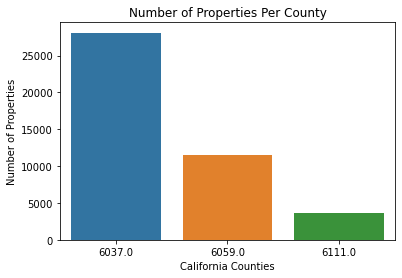

In [9]:
plt.title('Number of Properties Per County')
sns.countplot(df.fips)
plt.xlabel('California Counties')
plt.ylabel('Number of Properties')
plt.show()

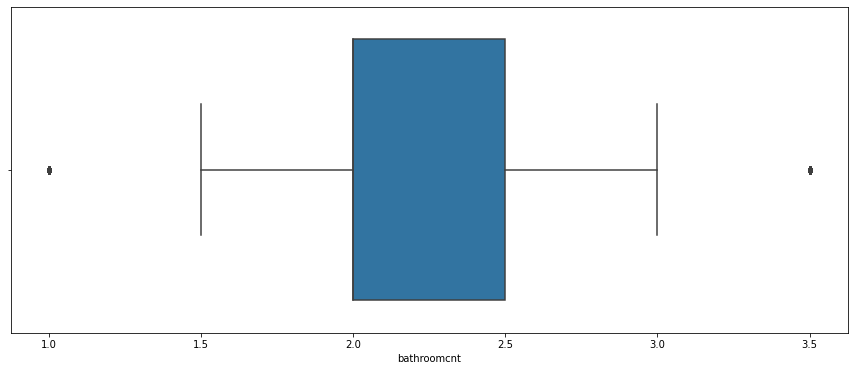

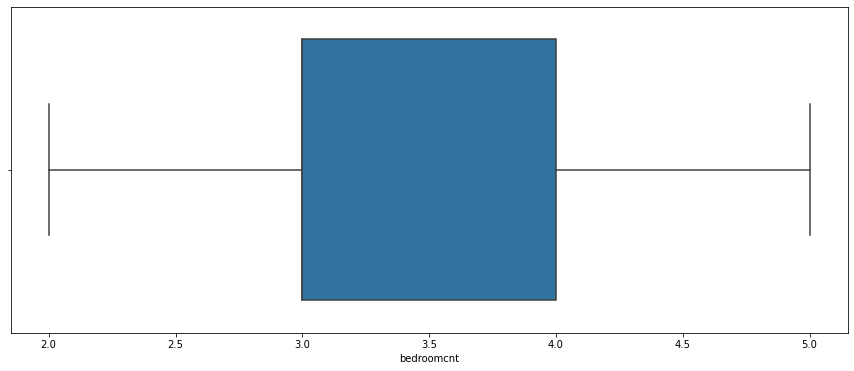

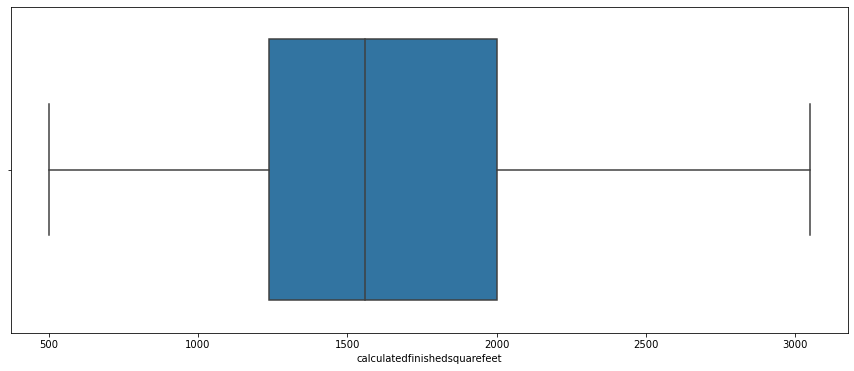

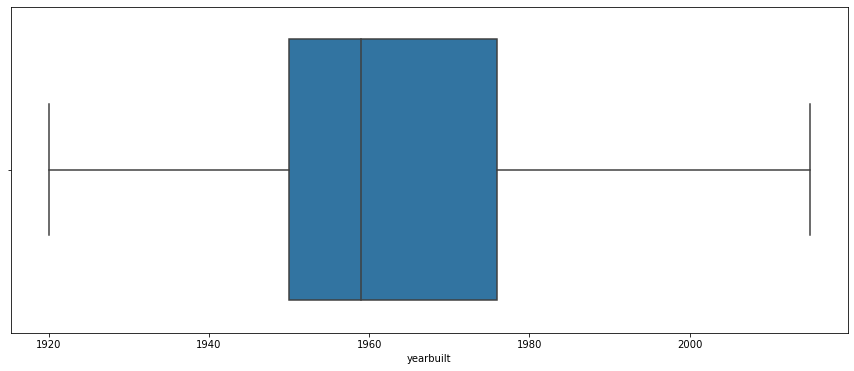

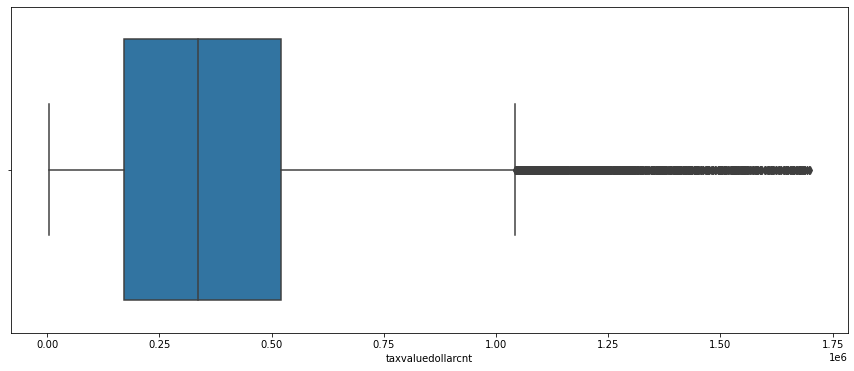

In [10]:
for column in ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt']:
    plt.figure(figsize=(15,6))
    sns.boxplot(x=column, data=df)
    plt.show()

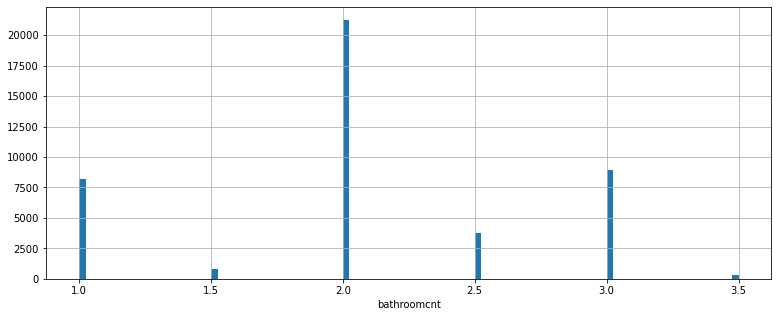

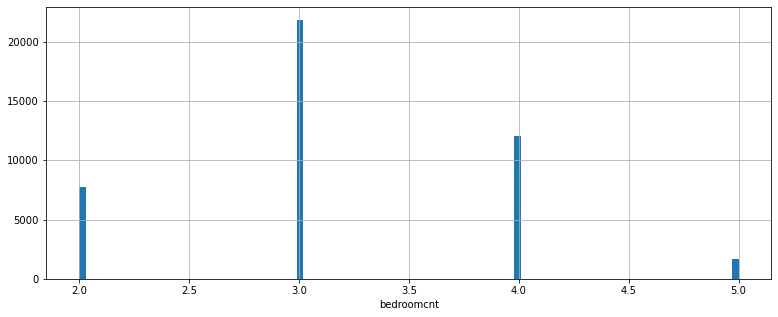

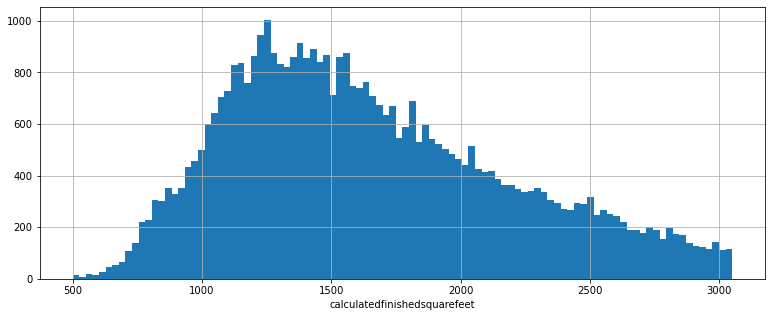

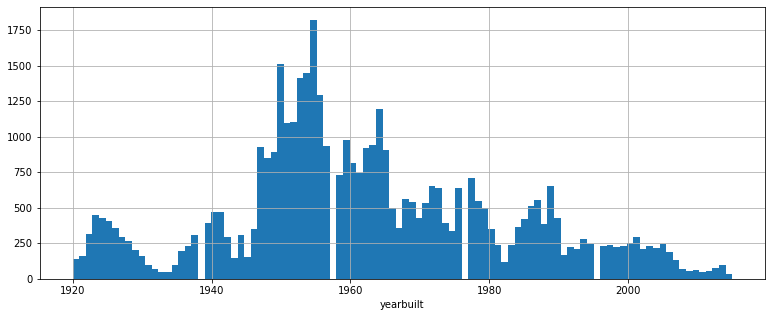

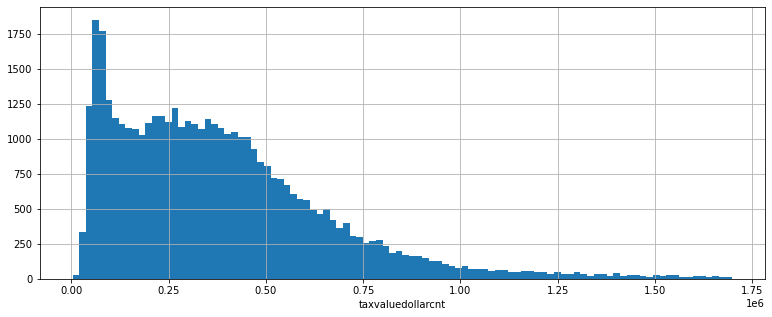

In [11]:
for column in ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt']:
    plt.figure(figsize=(13,5))
    df[column].hist(bins=100)
    plt.xlabel(column)
    plt.show()

In [12]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,2061.0,97099.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,1286.0,97078.0,1962.0,564778.0
3,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,3101.0,96330.0,1970.0,145143.0
4,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,3101.0,96293.0,1950.0,773303.0
5,1.0,2.0,738.0,6037.0,34149214.0,-118239357.0,3101.0,96325.0,1922.0,218552.0
...,...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,3101.0,96284.0,1940.0,354621.0
52438,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,2061.0,97116.0,1964.0,67205.0
52439,1.0,3.0,1032.0,6037.0,34040895.0,-118038169.0,3101.0,96480.0,1954.0,49546.0
52440,2.0,3.0,1762.0,6037.0,33937685.0,-117996709.0,3101.0,96171.0,1955.0,522000.0


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

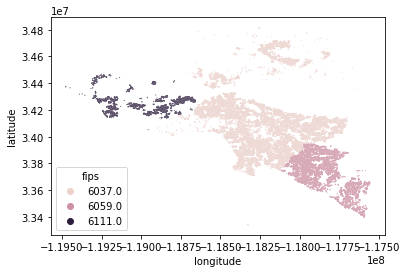

In [13]:
sns.scatterplot(df.longitude, df.latitude, s=1, hue= df.fips)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

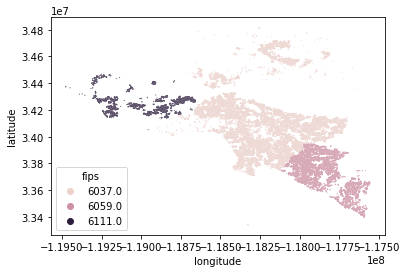

In [14]:
sns.scatterplot(df.longitude, df.latitude, s=1, hue= df.fips)

# Area of ventura county

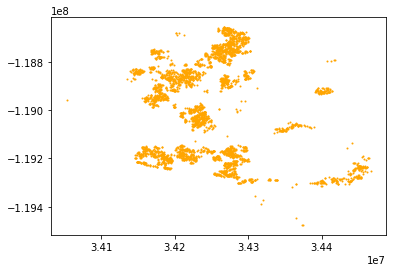

In [15]:
ventura = df[df.fips == 6111.0]
plt.scatter(ventura.latitude, ventura.longitude, s=1, c='orange')


# Area of Los Angeles county

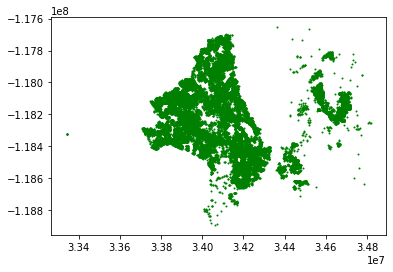

In [16]:
la = df[df.fips == 6037.0]
plt.scatter(la.latitude, la.longitude, s=1,c='green')

# Area of Orange county

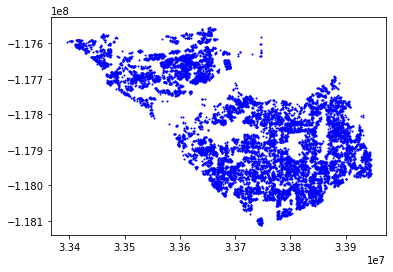

In [17]:
oc = df[df.fips == 6059.0]
plt.scatter(oc.latitude, oc.longitude, s=1,c='b')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43301 entries, 1 to 52441
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   43301 non-null  float64
 1   bedroomcnt                    43301 non-null  float64
 2   calculatedfinishedsquarefeet  43301 non-null  float64
 3   fips                          43301 non-null  float64
 4   latitude                      43301 non-null  float64
 5   longitude                     43301 non-null  float64
 6   regionidcounty                43301 non-null  float64
 7   regionidzip                   43301 non-null  float64
 8   yearbuilt                     43301 non-null  float64
 9   taxvaluedollarcnt             43301 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB


In [19]:
#Spliting my data
train, validate, test = prepare.split_zillow_data(df)

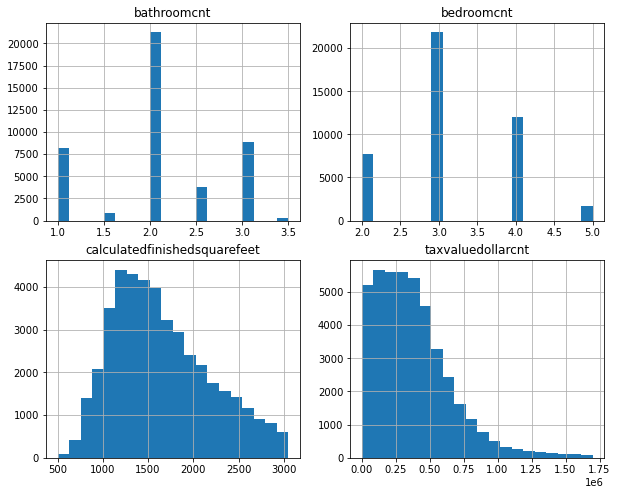

In [20]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(2,2, plot_number)
    plt.title(col)
    series.hist(bins=20)

In [21]:
mvp = df.copy()
mvp.astype(int)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt
1,1,2,1465,6111,34449266,-119281531,2061,97099,1967,464000
2,2,3,1243,6059,33886168,-117823170,1286,97078,1962,564778
3,3,4,2376,6037,34245180,-118240722,3101,96330,1970,145143
4,3,4,2962,6037,34145202,-118179824,3101,96293,1950,773303
5,1,2,738,6037,34149214,-118239357,3101,96325,1922,218552
...,...,...,...,...,...,...,...,...,...,...
52437,2,2,1286,6037,34245368,-118282383,3101,96284,1940,354621
52438,2,4,1612,6111,34300140,-118706327,2061,97116,1964,67205
52439,1,3,1032,6037,34040895,-118038169,3101,96480,1954,49546
52440,2,3,1762,6037,33937685,-117996709,3101,96171,1955,522000


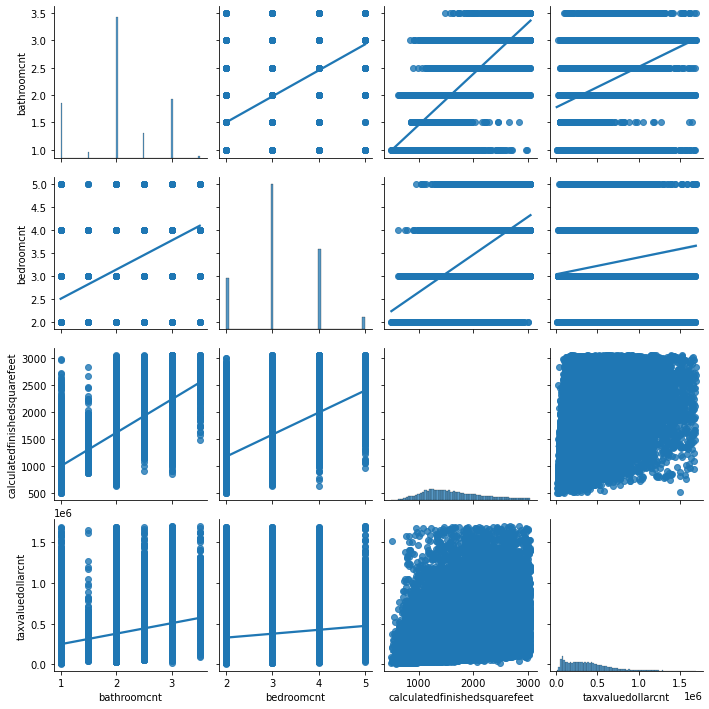

In [22]:
sns.pairplot(mvp,
            x_vars=['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt'],
            y_vars=['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt'],
            kind= "reg")

# DATA EXPLORATION

## Working on Our Most Valuable Payers that affect TaxValueDollarCount

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24248 entries, 21620 to 30622
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   24248 non-null  float64
 1   bedroomcnt                    24248 non-null  float64
 2   calculatedfinishedsquarefeet  24248 non-null  float64
 3   fips                          24248 non-null  float64
 4   latitude                      24248 non-null  float64
 5   longitude                     24248 non-null  float64
 6   regionidcounty                24248 non-null  float64
 7   regionidzip                   24248 non-null  float64
 8   yearbuilt                     24248 non-null  float64
 9   taxvaluedollarcnt             24248 non-null  float64
dtypes: float64(10)
memory usage: 2.0 MB


<AxesSubplot:xlabel='bathroomcnt', ylabel='taxvaluedollarcnt'>

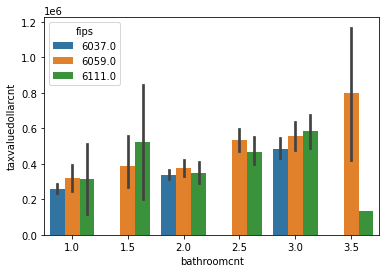

In [24]:
sns.barplot(x = 'bathroomcnt', y='taxvaluedollarcnt', hue = 'fips',data=train.sample(1000))

<AxesSubplot:>

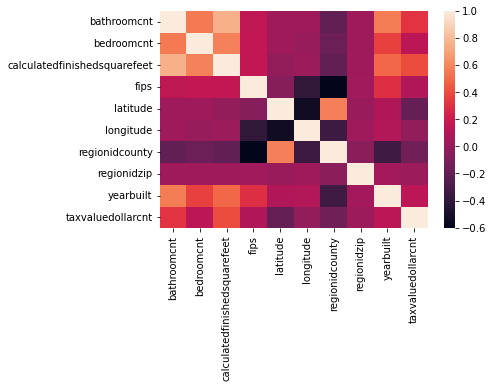

In [25]:
sns.heatmap(train.corr())

Text(0.5, 1.0, 'Distribution of Tax Rates')

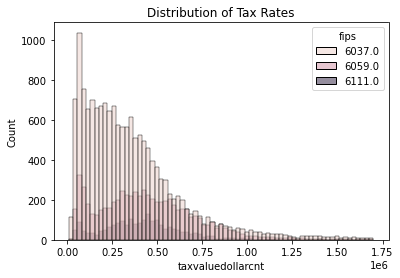

In [26]:
sns.histplot(data=train, x="taxvaluedollarcnt", hue = 'fips')
plt.title('Distribution of Tax Rates')

In [27]:
train.describe()[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt','fips']]

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips
count,24248.000000,24248.000000,24248.000000,2.424800e+04,24248.000000
mean,2.058046,3.172798,1650.215111,3.847227e+05,6049.104833
std,0.663678,0.765378,540.830997,2.764241e+05,21.090329
min,1.000000,2.000000,500.000000,9.242000e+03,6037.000000
25%,2.000000,3.000000,1236.000000,1.745400e+05,6037.000000
50%,2.000000,3.000000,1558.000000,3.374050e+05,6037.000000
75%,2.500000,4.000000,2002.000000,5.199752e+05,6059.000000
max,3.500000,5.000000,3049.000000,1.698819e+06,6111.000000


- Calculatedfinishedsqaurefeet has a large differance that has a significant affect on TaxValuedollarcount
- Bathroomcnt has a differance that has a moderate significant affect on TaxValuedollarcount
- Bedroomcnt has a differance that has a moderate significant affect on TaxValuedollarcount

well be focusing on calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt

# Hypothesis testing
- Correlation tests

In [28]:
alpha = 0.05

## calculatedfinishedsquarefeet & taxvaluedollarcnt (corr):
Null Hypothesis ${h_0}$ = there is no linear correlation between the calculatedfinishedsquarefeet of a home and taxvaluedollarcnt

Alternative Hypothesis ${h_a}$ = there is a linear correlation between the calculatedfinishedsquarefeet of a home and taxvaluedollarcnt

In [29]:
# corralation with sq ft and tax value dollar count
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.40099727421323567 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


## bathroomcnt & taxvaluedollarcnt (corr):
Null Hypothesis ${h_0}$ = there is no linear correlation between the bathroomcnt of a home and taxvaluedollarcnt

Alternative Hypothesis ${h_a}$ = there is a linear correlation between the bathroomcnt of a home and taxvaluedollarcnt

In [30]:
# corralation with bathroomcnt and tax value dollar count
corr, p = stats.pearsonr(train.bathroomcnt, train.taxvaluedollarcnt)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.3119308746935817 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


## bedroomcnt & taxvaluedollarcnt (corr):
Null Hypothesis ${h_0}$ = there is no linear correlation between the bedroomcnt of a home and taxvaluedollarcnt

Alternative Hypothesis ${h_a}$ = there is a linear correlation between the bedroomcnt of a home and taxvaluedollarcnt

In [31]:
# corralation with bedroomcnt and tax value dollar count
corr, p = stats.pearsonr(train.bedroomcnt, train.taxvaluedollarcnt)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.13584177525353153 , p value: 3.2656153560955047e-100
Pvalue is: 3.2656153560955047e-100 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


## regionidzip & taxvaluedollarcnt (corr):
Null Hypothesis ${h_0}$ = there is no linear correlation between the regionidzip of a home and taxvaluedollarcnt

Alternative Hypothesis ${h_a}$ = there is a linear correlation between the regionidzip of a home and taxvaluedollarcnt

In [32]:
# corralation with regionidzip and tax value dollar count
corr, p = stats.pearsonr(train.regionidzip, train.taxvaluedollarcnt)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.01990101779741487 , p value: 0.001941175405527872
Pvalue is: 0.001941175405527872 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


***

# spliting and scaling

In [33]:
X_train = train[['calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt']]
y_train = train['taxvaluedollarcnt']

X_validate = validate[['calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt']]
y_validate = validate['taxvaluedollarcnt']

X_test = test[['calculatedfinishedsquarefeet','bathroomcnt', 'bedroomcnt']]
y_test = test['taxvaluedollarcnt']

In [34]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = prepare.scale_data(X_train, X_validate, X_test, return_scaler=True)

***

# Modeling

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [36]:
y_train.describe()

count    2.424800e+04
mean     3.847227e+05
std      2.764241e+05
min      9.242000e+03
25%      1.745400e+05
50%      3.374050e+05
75%      5.199752e+05
max      1.698819e+06
Name: taxvaluedollarcnt, dtype: float64

In [37]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
# 1. Predict price_pred_mean
taxvaluedollarcnt_pred_mean = y_train.taxvaluedollarcnt.mean()
# creating a taxvalue_pred_mean column for my y_train
y_train['taxvaluedollarcnt_pred_mean'] = y_train.taxvaluedollarcnt.mean()
# creating a taxvalue_pred_mean column for my y_validate
y_validate['taxvaluedollarcnt_pred_mean'] = y_validate.taxvaluedollarcnt.mean()

In [38]:
# 2. compute price_pred_median
# creating a predictive median for y train 
y_train['taxvaluedollarcnt_pred_median'] = y_train.taxvaluedollarcnt.median()
# creating a predictive median for y_validate
y_validate['taxvaluedollarcnt_pred_median'] = y_validate.taxvaluedollarcnt.median()


In [39]:
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  276418.44 
Validate/Out-of-Sample:  277181.46


In [40]:
# 4. RMSE of taxvaluedollarcnt_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  280439.15 
Validate/Out-of-Sample:  281425.87


In [41]:

#predicting y from trained data
#predict rules
model = LinearRegression().fit(X_train_scaled, y_train.taxvaluedollarcnt)
predictions = model.predict(X_train_scaled)

In [42]:
y_test = pd.DataFrame(y_test)

y_test

,taxvaluedollarcnt
42751,520519.0
21269,460811.0
25934,472963.0
47293,408687.0
50195,329291.0
...,...
47199,757000.0
50411,130016.0
46797,551000.0
13963,160633.0


In [43]:
X_train_scaled

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
21620,0.464888,0.4,0.000000
2407,0.207925,0.4,0.333333
51380,0.295410,0.0,0.000000
41843,0.601805,0.8,0.666667
44774,0.414672,0.4,0.333333
...,...,...,...
16906,0.252256,0.4,0.333333
13577,0.704982,0.6,0.666667
13023,0.563750,0.4,0.333333
46246,0.445665,0.4,0.666667


# LinearRegression (ols)

In [44]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  250954.58515555505 
Validation/Out-of-Sample:  254020.8659488386


# LassoLars

In [45]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lars)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  250954.84367137836 
Validation/Out-of-Sample:  254020.75024149937


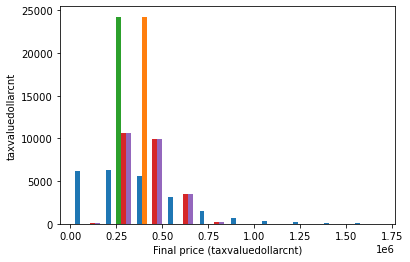

In [46]:
plt.hist(y_train)
plt.xlabel("Final price (taxvaluedollarcnt)")
plt.ylabel("taxvaluedollarcnt")
plt.show()


# TweedieRegressor (GLM)

In [47]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_glm)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  250861.42451571135 
Validation/Out-of-Sample:  254229.36340944044


# Polynomial Regression

In [48]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)


In [49]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm2)**(1/2)

# predict validate
y_validate['taxvaluedollarcnt_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  250608.11476052695 
Validation/Out-of-Sample:  253932.75470181863


In [50]:
y_test

,taxvaluedollarcnt
42751,520519.0
21269,460811.0
25934,472963.0
47293,408687.0
50195,329291.0
...,...
47199,757000.0
50411,130016.0
46797,551000.0
13963,160633.0


# Evaluating regression models

In [51]:
X_train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
21620,0.464888,0.4,0.000000
2407,0.207925,0.4,0.333333
51380,0.295410,0.0,0.000000
41843,0.601805,0.8,0.666667
44774,0.414672,0.4,0.333333


In [52]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(y_train.taxvaluedollarcnt)
X = pd.DataFrame(X_train_scaled)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)
train

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,yhat
21620,2.0,2.0,1685.0,6037.0,33986883.0,-118337715.0,3101.0,96024.0,1936.0,264846.0,455947.770099
2407,2.0,3.0,1030.0,6037.0,34047780.0,-117970197.0,3101.0,96490.0,1956.0,153579.0,251325.152302
51380,1.0,2.0,1253.0,6037.0,34124404.0,-118223851.0,3101.0,96046.0,1937.0,479773.0,334108.604749
41843,3.0,4.0,2034.0,6111.0,34302133.0,-118754068.0,2061.0,97118.0,2005.0,634530.0,448620.263748
44774,2.0,3.0,1557.0,6037.0,33906300.0,-118127339.0,3101.0,96208.0,1950.0,245376.0,371619.694414
...,...,...,...,...,...,...,...,...,...,...,...
16906,2.0,3.0,1143.0,6037.0,34205157.0,-118514120.0,3101.0,96415.0,1950.0,56691.0,277118.858675
13577,2.5,4.0,2297.0,6111.0,34188159.0,-119205314.0,2061.0,97106.0,1969.0,82676.0,497038.604550
13023,2.0,3.0,1937.0,6059.0,33457060.0,-117639428.0,1286.0,96983.0,1984.0,81767.0,458359.591953
46246,2.0,4.0,1636.0,6037.0,33989390.0,-117983680.0,3101.0,96489.0,1973.0,485955.0,334542.036600


In [53]:
df = pd.DataFrame(train[['calculatedfinishedsquarefeet','bathroomcnt','bedroomcnt','taxvaluedollarcnt','yhat']])
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt,yhat
21620,1685.0,2.0,2.0,264846.0,455947.770099
2407,1030.0,2.0,3.0,153579.0,251325.152302
51380,1253.0,1.0,2.0,479773.0,334108.604749
41843,2034.0,3.0,4.0,634530.0,448620.263748
44774,1557.0,2.0,3.0,245376.0,371619.694414


In [54]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.taxvaluedollarcnt.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.taxvaluedollarcnt - df.yhat
df['baseline_residual'] = df.taxvaluedollarcnt - df.baseline

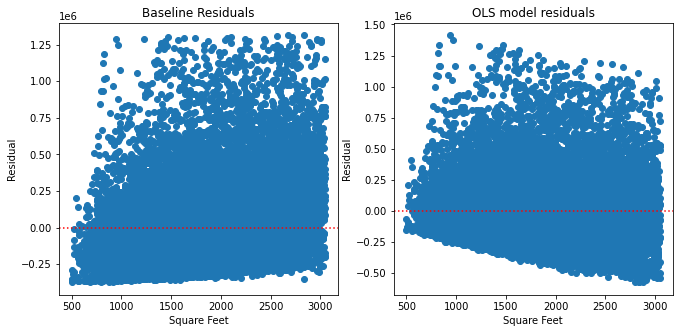

In [55]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(df.calculatedfinishedsquarefeet, df.baseline_residual)
plt.axhline(y = 0, ls = ':', color='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(df.calculatedfinishedsquarefeet, df.residual)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals');


In [104]:
## important
df

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
21620,1685.0,2.0,2.0,264846.0,455947.770099,384722,-191101.770099,-119876.0,3.651989e+10,1.437026e+10
2407,1030.0,2.0,3.0,153579.0,251325.152302,384722,-97746.152302,-231143.0,9.554310e+09,5.342709e+10
51380,1253.0,1.0,2.0,479773.0,334108.604749,384722,145664.395251,95051.0,2.121812e+10,9.034693e+09
41843,2034.0,3.0,4.0,634530.0,448620.263748,384722,185909.736252,249808.0,3.456243e+10,6.240404e+10
44774,1557.0,2.0,3.0,245376.0,371619.694414,384722,-126243.694414,-139346.0,1.593747e+10,1.941731e+10
...,...,...,...,...,...,...,...,...,...,...
16906,1143.0,2.0,3.0,56691.0,277118.858675,384722,-220427.858675,-328031.0,4.858844e+10,1.076043e+11
13577,2297.0,2.5,4.0,82676.0,497038.604550,384722,-414362.604550,-302046.0,1.716964e+11,9.123179e+10
13023,1937.0,2.0,3.0,81767.0,458359.591953,384722,-376592.591953,-302955.0,1.418220e+11,9.178173e+10
46246,1636.0,2.0,4.0,485955.0,334542.036600,384722,151412.963400,101233.0,2.292589e+10,1.024812e+10


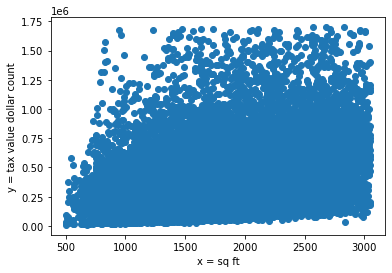

In [56]:
y = pd.DataFrame(df.taxvaluedollarcnt)
X = pd.DataFrame(df.calculatedfinishedsquarefeet)
# look at scatter of x vs y
plt.scatter(X, y)
plt.xlabel('x = sq ft')
plt.ylabel('y = tax value dollar count');

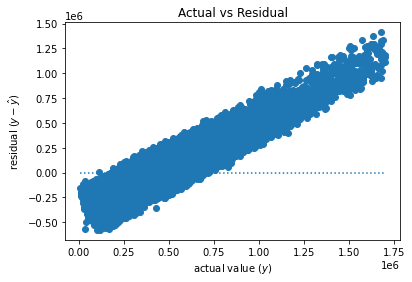

In [57]:
# Residual plot (y vs residual)
actual = y_train.taxvaluedollarcnt
predicted = df.yhat
residuals = actual - predicted
plt.hlines(0, actual.min(), actual.max(), ls=':')
plt.scatter(actual, residuals)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title('Actual vs Residual')
plt.show()


In [58]:
# sum of residual is zero
df.residual.sum()

5.19677996635437e-07

In [59]:
# sum of baseline residual is zero too
df.baseline_residual.sum()

16309.0

In [60]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
21620,1685.0,2.0,2.0,264846.0,455947.770099,384722,-191101.770099,-119876.0,3.651989e+10,1.437026e+10
2407,1030.0,2.0,3.0,153579.0,251325.152302,384722,-97746.152302,-231143.0,9.554310e+09,5.342709e+10
51380,1253.0,1.0,2.0,479773.0,334108.604749,384722,145664.395251,95051.0,2.121812e+10,9.034693e+09
41843,2034.0,3.0,4.0,634530.0,448620.263748,384722,185909.736252,249808.0,3.456243e+10,6.240404e+10
44774,1557.0,2.0,3.0,245376.0,371619.694414,384722,-126243.694414,-139346.0,1.593747e+10,1.941731e+10


In [61]:
SSE = df['residual^2'].sum()
SSE_baseline = df['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

if SSE < SSE_baseline:
    print('SSE is better than baseline')
else:
    print('baseline is better')

SSE = 1527095485999349.5
SSE Baseline = 1852720624276517.0
SSE is better than baseline


In [62]:
len(df)
df.shape[0]

24248

In [63]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

MSE =  62978203810.6
MSE baseline =  76407152106.4
MSE is better than baseline


In [64]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE is better than baseline
RMSE =  250954.6
RMSE baseline =  276418.4


In [65]:
# take away 223,000 rmse basline that gives me a price range predictor of give or take 223 k

In [66]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

OLS regression model performs better than the baseline


In [67]:
# sklearn.metrics.explained_variance_score

evs = explained_variance_score(df.taxvaluedollarcnt, df.yhat)
print('Explained Variance = ', round(evs,3))


Explained Variance =  0.176


In [68]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.taxvaluedollarcnt, df.yhat)

0.17575512141517924

In [69]:
X2 = sm.add_constant(df.calculatedfinishedsquarefeet)
est = sm.OLS(df.taxvaluedollarcnt, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4646.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:53:48   Log-Likelihood:            -3.3610e+05
No. Observations:               24248   AIC:                         6.722e+05
Df Residuals:                   24246   BIC:                         6.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [70]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 score
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)
#_____________________________________________________________________________________
def regression_errors(actual, predicted):
    return pd.Series({
        'SSE': sse(actual, predicted),
        'ESS': ess(actual, predicted),
        'TSS': tss(actual),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
        'SSE': sse(actual, predicted),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [71]:
regression_errors(actual,predicted)

SSE     1.527095e+15
ESS     3.256251e+14
TSS     1.852721e+15
MSE     6.297820e+10
RMSE    2.509546e+05
dtype: float64

In [72]:
baseline_mean_errors(actual)

{'SSE': 1852720624265547.5,
 'MSE': 76407152105.96947,
 'RMSE': 276418.43662456644}

In [73]:
better_than_baseline(actual, predicted)

True

# evaluate

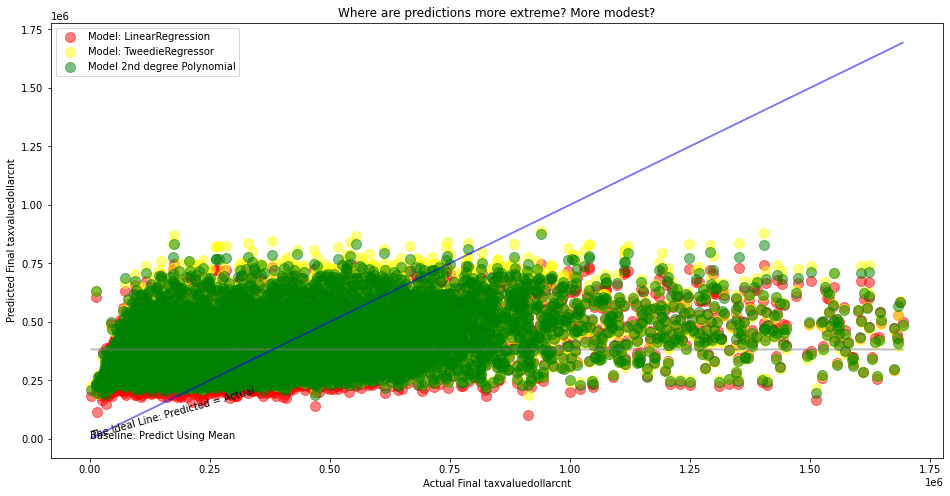

In [74]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final taxvaluedollarcnt")
plt.ylabel("Predicted Final taxvaluedollarcnt")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

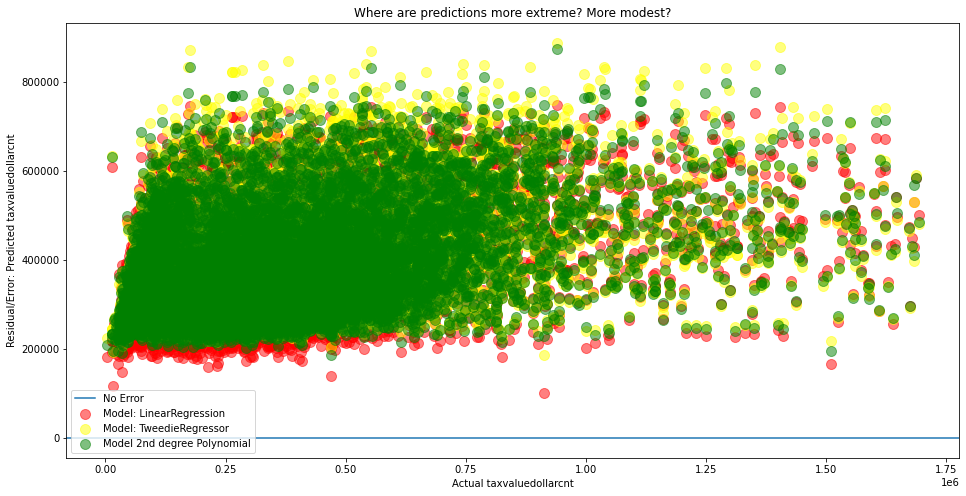

In [94]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual taxvaluedollarcnt")
plt.ylabel("Residual/Error: Predicted taxvaluedollarcnt")
plt.title("Where are predictions more extreme? More modest?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


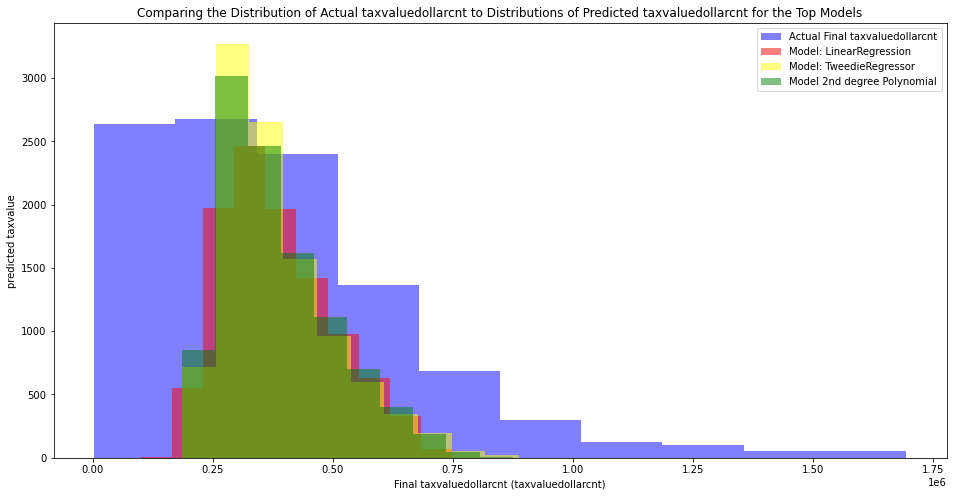

In [95]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Final taxvaluedollarcnt")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.taxvaluedollarcnt_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.taxvaluedollarcnt_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final taxvaluedollarcnt (taxvaluedollarcnt)")
plt.ylabel("predicted taxvalue")
plt.title("Comparing the Distribution of Actual taxvaluedollarcnt to Distributions of Predicted taxvaluedollarcnt for the Top Models")
plt.legend()
plt.show()


In [77]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvaluedollarcnt_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvaluedollarcnt_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)


RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  1010209555.2753793


In [78]:
y_train.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean,taxvaluedollarcnt_pred_median,taxvaluedollarcnt_pred_lm,taxvaluedollarcnt_pred_lars,taxvaluedollarcnt_pred_glm,taxvaluedollarcnt_pred_lm2
21620,264846.0,384722.672592,337405.0,455947.770099,455335.887474,435015.529951,451170.650359
2407,153579.0,384722.672592,337405.0,251325.152302,251526.241591,271298.539003,251686.714350
51380,479773.0,384722.672592,337405.0,334108.604749,333979.575199,319697.897135,328086.586744
41843,634530.0,384722.672592,337405.0,448620.263748,448608.335677,438389.516539,445107.647639
44774,245376.0,384722.672592,337405.0,371619.694414,371587.505157,357751.582165,358147.611100


In [79]:
y_validate.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean,taxvaluedollarcnt_pred_median,taxvaluedollarcnt_pred_lm,taxvaluedollarcnt_pred_lars,taxvaluedollarcnt_pred_glm,taxvaluedollarcnt_pred_lm2
15175,300000.0,381837.024731,333144.5,506370.774478,506246.854998,500649.342674,505790.855183
34706,795000.0,381837.024731,333144.5,562295.182101,562062.812443,569355.437782,566644.433945
39276,555000.0,381837.024731,333144.5,344585.603683,345022.001690,335641.720097,340297.336774
19709,494957.0,381837.024731,333144.5,273923.178240,274080.444804,285769.149635,270960.463565
38080,202884.0,381837.024731,333144.5,221475.930921,221981.483807,246348.392290,244356.132512


In [80]:
y_test.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_lm
42751,520519.0,1.664325e+09
21269,460811.0,7.683958e+08
25934,472963.0,9.225840e+08
47293,408687.0,8.417079e+08
50195,329291.0,9.900776e+08


In [81]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 scor
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)
#____________________________________________________________________________________________________________________________________________________________


def regression_errors(actual, predicted):
    return pd.Series({
        'SSE': sse(actual, predicted),
        'ESS': ess(actual, predicted),
        'TSS': tss(actual),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
        'SSE': sse(actual, predicted),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [82]:
regression_errors(actual, predicted)

SSE     1.527095e+15
ESS     3.256251e+14
TSS     1.852721e+15
MSE     6.297820e+10
RMSE    2.509546e+05
dtype: float64

In [83]:
better_than_baseline(actual, predicted)

True

In [84]:
baseline_mean_errors(actual)

{'SSE': 1852720624265547.5,
 'MSE': 76407152105.96947,
 'RMSE': 276418.43662456644}

In [85]:
residuals(actual, predicted)

21620   -191101.770099
2407     -97746.152302
51380    145664.395251
41843    185909.736252
44774   -126243.694414
             ...      
16906   -220427.858675
13577   -414362.604550
13023   -376592.591953
46246    151412.963400
30622   -265195.785024
Length: 24248, dtype: float64

In [86]:
sse(actual, predicted)

1527095485999349.5

In [87]:
ess(actual, predicted)

325625138266199.4

In [88]:
rmse(actual, predicted)

250954.58515555505

In [89]:
r2_score(actual, predicted)

0.17575512141518

In [96]:
df

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
21620,1685.0,2.0,2.0,264846.0,455947.770099,384722,-191101.770099,-119876.0,3.651989e+10,1.437026e+10
2407,1030.0,2.0,3.0,153579.0,251325.152302,384722,-97746.152302,-231143.0,9.554310e+09,5.342709e+10
51380,1253.0,1.0,2.0,479773.0,334108.604749,384722,145664.395251,95051.0,2.121812e+10,9.034693e+09
41843,2034.0,3.0,4.0,634530.0,448620.263748,384722,185909.736252,249808.0,3.456243e+10,6.240404e+10
44774,1557.0,2.0,3.0,245376.0,371619.694414,384722,-126243.694414,-139346.0,1.593747e+10,1.941731e+10
...,...,...,...,...,...,...,...,...,...,...
16906,1143.0,2.0,3.0,56691.0,277118.858675,384722,-220427.858675,-328031.0,4.858844e+10,1.076043e+11
13577,2297.0,2.5,4.0,82676.0,497038.604550,384722,-414362.604550,-302046.0,1.716964e+11,9.123179e+10
13023,1937.0,2.0,3.0,81767.0,458359.591953,384722,-376592.591953,-302955.0,1.418220e+11,9.178173e+10
46246,1636.0,2.0,4.0,485955.0,334542.036600,384722,151412.963400,101233.0,2.292589e+10,1.024812e+10


In [97]:
RMSE2 = sqrt(mean_squared_error(df.taxvaluedollarcnt, df.yhat))
RMSE2_baseline = sqrt(mean_squared_error(df.taxvaluedollarcnt, df.yhat_baseline))

print("RMSE manual == RMSE skearn: ", RMSE == RMSE2) 
print("RMSE manual - baseline == RMSE skearn - baseline: ", RMSE_baseline == RMSE2_baseline) 


AttributeError: 'DataFrame' object has no attribute 'yhat_baseline'